# 0. Magic

In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import

In [0]:
import torch
from torch import tensor
from torch import nn
import torch.nn.functional as F
from torch.utils import data 
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
from fastai.metrics import accuracy
import pickle, gzip, math, torch
import operator

# 2. Data

In [0]:
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [0]:
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train, y_train, x_valid, y_valid))

In [0]:
x_train, y_train, x_valid, y_valid = get_data()

# 3. เตรียม Data

In [0]:
class Dataset(data.Dataset):
    def __init__(self, x, y):
        self.x, self.y = x, y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [0]:
class DataLoader():
    def __init__(self, ds, bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [0]:
# x = data, m = mean, s = standard deviation
def normalize(x, m, s): 
    return (x-m)/s

In [9]:
n, m = x_train.shape
c = (y_train.max()+1).numpy()
n, m, c

(50000, 784, array(10))

In [0]:
train_mean, train_std = x_train.mean(), x_train.std()
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

In [0]:
# batch size
bs = 64
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
train_dl, valid_dl = DataLoader(train_ds, bs), DataLoader(valid_ds, bs)

# 4. สร้าง Model

Hyperparameter ของโมเดล

In [0]:
# learning rate
lr = 0.03
epoch = 1
nh = 50

ประกาศฟังก์ชันเอาไว้สร้างโมเดล

In [0]:
def get_model():
    # loss function
    loss_func = F.cross_entropy
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh,c))
    return model, loss_func

# 5. Training Loop

เราจะเทรนโมเดล ด้วยอัลกอริทึม [Stochastic Gradient Descent (SGD)](https://www.bualabs.com/wp-admin/post.php?post=631&action=edit) และ เก็บ Loss, Accuracy เอาไว้พล็อตกราฟ

ประกาศฟังก์ชัน fit เอาไว้เรียกเทรนเวลาที่ต้องการ

In [0]:
def fit():
    losses, metrics = [], []
    # e = epoch number
    for e in range(epoch):
        for xb, yb in train_dl:

            # Feedforward
            yhatb = model(xb)
            loss = loss_func(yhatb, yb)

            # Metrics
            acc = accuracy(yhatb, yb)
            losses.append(loss); metrics.append(acc)

            # Backpropagation
            loss.backward()

            optim.step()
            optim.zero_grad()

    plot_metrics(losses, metrics)

ประการฟัง์ชัน ไว้พล็อตกราฟ Loss และ Accuracy

In [0]:
def plot_metrics(losses, metrics):
    x = torch.arange(len(losses)).numpy()
    fig,ax = plt.subplots(figsize=(9, 9))
    ax.grid(True)
    ax.plot(x, losses, label="Loss")
    ax.plot(x, metrics, label="Accuracy")
    ax.legend(loc='upper right')

# 6. Refactor DataLoader

## 6.1 Random Sampler

ในการเทรนโมเดล เราควรสับเปลี่ยนกองข้อมูล เหมือนสับไพ่ ให้ลำดับข้อมูลตัวอย่างไม่เหมือนกันทุกครั้ง ก่อนที่จะป้อนให้กับโมเดล

In [0]:
class Sampler():
    # ds = Dataset, bs = Batch Size, n = Length of Dataset
    def __init__(self, ds, bs, shuffle=False):
        self.n, self.bs, self.shuffle = len(ds), bs, shuffle
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [0]:
small_ds = Dataset(*train_ds[:10])

เทสแบบไม่สับเปลี่ยน

In [18]:
s = Sampler(small_ds, 3, shuffle=False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

เทสแบบสับเปลี่ยน

In [19]:
s = Sampler(small_ds, 3, shuffle=True)
[o for o in s]

[tensor([0, 9, 7]), tensor([2, 8, 3]), tensor([4, 6, 1]), tensor([5])]

## 6.2 Collate

เมื่อเราสับเปลี่ยนข้อมูลออกมาจากกอง Dataset เป็น (x7, y7), (x3, y3), (x1, y1), (...) แล้ว เราต้องมีฟังก์ชันเล็ก ๆ ใน DataLoader ในการรวมเป็นกองเล็ก ๆ ขึ้นมาใหม่ เป็น Mini-Batch (x7, x3, x1, ...), (y7, y3, y1, ...) ก่อนส่งให้กับโมเดล

In [0]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

เพิ่ม Feature ให้กับ DataLoader ในการรับ Sampler และ Collate

In [0]:
class DataLoader2():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds, self.sampler, self.collate_fn = ds, sampler, collate_fn
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

เรามักจะ Shuffle ข้อมูล Training Set แต่ Validation Set ไม่จำเป็นต้อง Shuffle

In [0]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [0]:
# train_dl = Training Set DataLoader, valid_dl = Validation Set DataLoader
train_dl = DataLoader2(train_ds, train_samp, collate)
valid_dl = DataLoader2(valid_ds, valid_samp, collate)

(tensor(1), <matplotlib.image.AxesImage at 0x7f19c19a5390>)

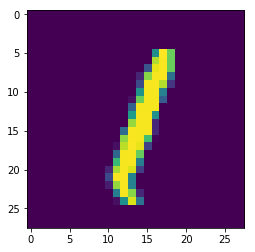

In [24]:
xb, yb = next(iter(train_dl))
yb[0], plt.imshow(xb[0].view(28, 28))

(tensor(1), <matplotlib.image.AxesImage at 0x7f19c1133588>)

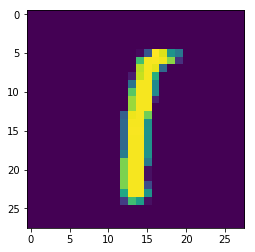

In [25]:
xb, yb = next(iter(train_dl))
yb[0], plt.imshow(xb[0].view(28, 28))

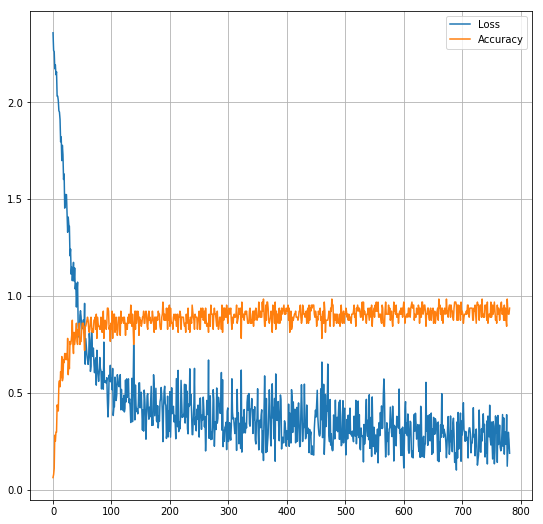

In [26]:
model, loss_func = get_model()
optim = torch.optim.SGD(model.parameters(), lr=lr)
fit()

## 6.3 PyTorch DataLoader

In [0]:
from torch.utils import data

PyTorch DataLoader สามารถรับ shuffle=True/False หรือ รับเป็น class RandomSampler/SequentialSampler ก็ได้

In [0]:
# train_dl = data.DataLoader(train_ds, bs, shuffle=True, collate_fn=collate)
# valid_dl = data.DataLoader(valid_ds, bs, shuffle=False, collate_fn=collate)
train_dl = data.DataLoader(train_ds, bs, sampler=data.RandomSampler(train_ds), collate_fn=collate, num_workers=8)
valid_dl = data.DataLoader(valid_ds, bs, sampler=data.SequentialSampler(valid_ds), collate_fn=collate, num_workers=8)

เราสามารถ ใช้ num_workers เพื่อกำหนดให้ PyTorch DataLoader แตก SubProcess เพื่อช่วยโหลดข้อมูลแบบขนาน ทำให้โหลดข้อมูลขนาดใหญ่ได้เร็วขึ้น

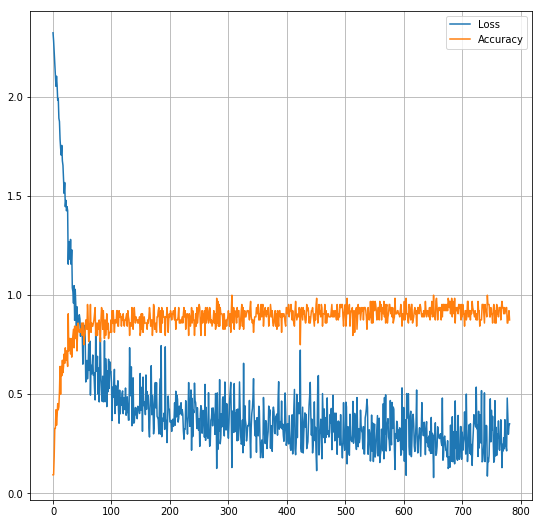

In [29]:
model, loss_func = get_model()
optim = torch.optim.SGD(model.parameters(), lr=lr)
fit()

# 7. สรุป

1. ในการเทรนโมเดล แต่ละ Epoch เราไม่ควรป้อนข้อมูลเหมือน ๆ กันทุกครั้งให้โมเดล เราจึงได้สร้าง DataLoader เวอร์ชันใหม่ ที่จะสับไพ่ข้อมูลตัวอย่างก่อนป้อนให้โมเดล
1. ในการสับไพ่ข้อมูล จำเป็นต้องมีกระบวนการนำข้อมูลมารวมกันใหม่ เรียกว่า Collate
1. DataLoader ของ PyTorch จัดการปัญหาพวกนี้ให้เราหมด พร้อมทั้งมี Feature num_workers เพิ่มความเร็วในการโหลดข้อมูล แบบขนาน

# Credit

* https://course.fast.ai/videos/?lesson=9
* https://pytorch.org/docs/stable/data.html